In [1]:
# Some useful modules for notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
# select GPU 1
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
from diffusers import DiffusionPipeline
from scipy import signal
import numpy as np
import torch
import matplotlib.pyplot as plt
import h5py
from tqdne.conf import DATASETDIR
from pathlib import Path
from tqdne.dataset import UpsamplingDataset, RandomDataset
from torch.utils.data import DataLoader
from diffusers import UNet1DModel
from diffusers import DDPMScheduler
#from tqdne.diffusers import DDPMPipeline1DCond
from tqdne.diffusion import LightningDDMP

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pathlib import Path
from pytorch_lightning.loggers import WandbLogger

from tqdne.conf import OUTPUTDIR, PROJECT_NAME

import pytorch_lightning as pl


/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [5]:
DATASETDIR = Path("/users/abosisio/scratch/tqdne/datasets")

In [6]:
# Create very simple synthetic dataset

t = (5501 // 32) * 32
batch_size = 32


path_train = DATASETDIR / Path("data_upsample_train.h5")
path_test = DATASETDIR / Path("data_upsample_test.h5")
train_dataset = UpsamplingDataset(path_train, cut=t)
test_dataset = UpsamplingDataset(path_test, cut=t)

# train_dataset = RandomDataset(1024*8, t=t)
# test_dataset = RandomDataset(512, t=t)

channels = train_dataset[0]["high_res"].shape[0]

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=4)
channels

3

In [8]:
low_res, high_res = train_dataset[:]["low_res"], train_dataset[:]["high_res"]

low_res.shape, high_res.shape


(torch.Size([100, 3, 5501]), torch.Size([100, 3, 5501]))

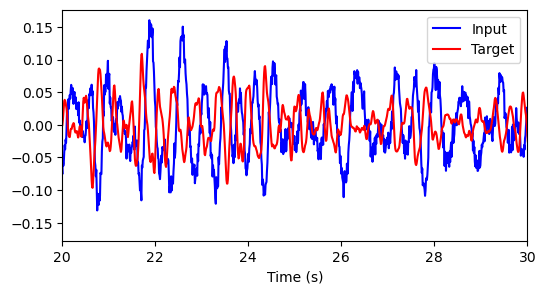

In [12]:
fs = 100
t = low_res.shape[-1]
time = np.arange(0, t)/fs

plt.figure(figsize=(6, 3))
plt.plot(time ,low_res[10, 0].numpy(), 'b', label="Input")
plt.plot(time, high_res[10, 0].numpy(), 'r', label="Target")
plt.xlabel("Time (s)")
plt.xlim(20, 30)
plt.legend()

In [14]:
batch = next(iter(train_loader))
batch_low, batch_high = batch['low_res'], batch['high_res']
batch_low.shape, batch_high.shape

(torch.Size([32, 3, 5472]), torch.Size([32, 3, 5472]))

In [21]:
max_epochs = 50
prediction_type = "sample" # `epsilon` (predicts the noise of the diffusion process) or `sample` (directly predicts the noisy sample`

# Unet parameters
unet_params = {
    "sample_size":t,
    "in_channels":channels*2, 
    "out_channels":channels,
    "block_out_channels":  (32, 64, 128),
    "down_block_types": ('DownBlock1D', 'DownBlock1D', 'AttnDownBlock1D'),
    "up_block_types": ('AttnUpBlock1D', 'UpBlock1D', 'UpBlock1D'),
    "mid_block_type": 'UNetMidBlock1D',
    "out_block_type": "OutConv1DBlock",
    "extra_in_channels" : 0,
    "act_fn": 'relu',
}

scheduler_params = {
    "beta_schedule": "linear",
    "beta_start": 0.0001,
    "beta_end": 0.02,
    "num_train_timesteps": 1000,
    "prediction_type": prediction_type, 
    "clip_sample": False,
}

optimizer_params = {
    "learning_rate": 1e-4,
    "lr_warmup_steps": 500,
    "n_train": len(train_dataset) // batch_size,
    "seed": 0,
    "batch_size": batch_size,
    "max_epochs": max_epochs,
}

trainer_params = {
    # trainer parameters
    "accumulate_grad_batches": 1,
    "gradient_clip_val": 1,
    "precision": "32-true",  
    # Double precision (64, '64' or '64-true'), full precision (32, '32' or '32-true'),
    # 16bit mixed precision (16, '16', '16-mixed') or bfloat16 mixed precision ('bf16', 'bf16-mixed').
    # Can be used on CPU, GPU, TPUs, HPUs or IPUs.
    "max_epochs": max_epochs,
    "accelerator": "auto",
    "devices": "auto",
    "num_nodes": 1}


In [22]:
net = UNet1DModel(**unet_params)
net.config

FrozenDict([('sample_size', 5501),
            ('sample_rate', None),
            ('in_channels', 6),
            ('out_channels', 3),
            ('extra_in_channels', 0),
            ('time_embedding_type', 'fourier'),
            ('flip_sin_to_cos', True),
            ('use_timestep_embedding', False),
            ('freq_shift', 0.0),
            ('down_block_types',
             ('DownBlock1D', 'DownBlock1D', 'AttnDownBlock1D')),
            ('up_block_types', ('AttnUpBlock1D', 'UpBlock1D', 'UpBlock1D')),
            ('mid_block_type', 'UNetMidBlock1D'),
            ('out_block_type', 'OutConv1DBlock'),
            ('block_out_channels', (32, 64, 128)),
            ('act_fn', 'relu'),
            ('norm_num_groups', 8),
            ('layers_per_block', 1),
            ('downsample_each_block', False),
            ('_use_default_values',
             ['layers_per_block',
              'flip_sin_to_cos',
              'freq_shift',
              'norm_num_groups',
              'down

In [ ]:
def to_inputs(low_res, high_res):
    """Build Unet inputs from low and high resolution data."""
    return torch.cat((low_res, high_res), dim=1)
high_resn = torch.rand(batch_size, channels,t)

inputs = to_inputs(batch_low, high_resn)
timesteps = torch.LongTensor([150]*batch_size)
print(inputs.shape)
assert net(inputs, timesteps).sample.shape == batch_high.shape


In [23]:
scheduler = DDPMScheduler(**scheduler_params)
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', False),
            ('prediction_type', 'sample'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('_use_default_values',
             ['dynamic_thresholding_ratio',
              'thresholding',
              'variance_type',
              'clip_sample_range',
              'trained_betas',
              'sample_max_value',
              'steps_offset',
              'timestep_spacing'])])

ValueError: x and y must have same first dimension, but have shapes (5501,) and (5472,)

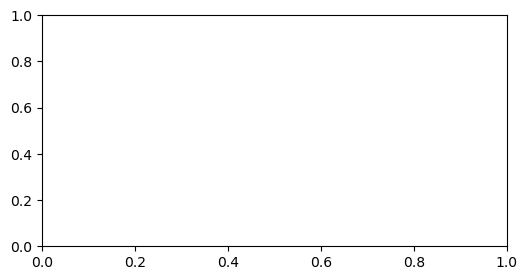

In [25]:
noise = torch.randn(batch_high.shape)
timesteps = torch.LongTensor([50]*batch_size)
noisy_sig = scheduler.add_noise(batch_high, noise, timesteps)
plt.figure(figsize=(6, 3))
plt.plot(time, noisy_sig[0,0].numpy(), 'b', label="noisy")
plt.plot(time, batch_high[0,0].numpy(), 'r',  label="original")
plt.xlim(1, 5)
plt.legend()

In [ ]:
# # this is probably wrong because of the conditioning
# import tqdm

# def sample(noise):
#     sample = noise
#     for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
#         # 1. predict noise residual
#         with torch.no_grad():
#             residual = net(sample, t).sample
#         # 2. compute less noisy image and set x_t -> x_t-1
#         sample = scheduler.step(residual, t, sample).prev_sample

#     return sample

# import torch.nn.functional as F

# sample = train_dataset[0]
# sig = sample.unsqueeze(0)
# print(sig.shape)
# noise = torch.randn(sig[:,:1].shape)
# timesteps = torch.LongTensor([150])
# noisy_sig = scheduler.add_noise(sig[:,:1], noise, timesteps)
# noisy_sig = torch.concat([noisy_sig, sig[:,1:]], dim=1)
# noise_pred = net(noisy_sig, timesteps).sample
# loss = F.mse_loss(noise_pred, noise)

In [ ]:
pipeline = DDPMPipeline1DCond(net, scheduler)

In [ ]:
# def evaluate(low_res, pipeline):
#     # Sample some signaol from random noise (this is the backward diffusion process).
#     sig = pipeline(
#         low_res = low_res,
#         generator=torch.manual_seed(optimizer_params["seed"]),
#     ).audios

#     return sig

# batch_low, batch_high = next(iter(train_loader))
# gen_high = evaluate(batch_low, pipeline)

# plt.plot(time, batch_high[0,0].numpy(), 'b', label="high res")
# plt.plot(time, batch_low[0,0].numpy(), 'r', label="low res")
# plt.plot(time, gen_high[0,0].numpy(), 'g', alpha=0.5, label="generated")
# plt.legend()
# plt.xlim(1, 5)


In [ ]:
model = LightningDDMP(net, scheduler, prediction_type=prediction_type, optimizer_params=optimizer_params)

In [ ]:
# batch = next(iter(train_loader))

# low_res, high_res = batch

# # Sample noise to add to the high_res
# noise = torch.randn(high_res.shape).to(high_res.device)
# batch_size = high_res.shape[0]
# # Sample a random timestep for each signal
# timesteps = torch.randint(
#     0,
#     scheduler.config.num_train_timesteps,
#     (batch_size,),
#     device=high_res.device,
# ).long()
# timesteps[0] = 150

# noisy_hig_res = scheduler.add_noise(high_res, noise, timesteps)

# # Predict the noise residual
# inputs = to_inputs(low_res, noisy_hig_res)
# noise_pred = net(inputs, timesteps, return_dict=False)[0]

# plt.figure(figsize=(6, 3))
# plt.plot(time, low_res[0,0].numpy(), 'b', label="low res")
# plt.plot(time, high_res[0,0].numpy(), 'r', label="high res")
# plt.plot(time, noisy_hig_res[0,0].numpy(), 'g', label="noisy high res", alpha=0.5)
# plt.legend()
# plt.xlim(1, 5)
# plt.figure(figsize=(6, 3))
# plt.plot(time, noise[0,0].numpy(), 'b', label="noise", alpha=1)
# plt.plot(time, noise_pred[0,0].detach().cpu().numpy(), 'g', label="predicted noise")
# plt.legend()
# plt.xlim(1, 5)

# noise_pred.min(), noise_pred.max()

In [ ]:
name = '1D-UNET'

# 1. Wandb Logger
wandb_logger = WandbLogger(project=PROJECT_NAME) # add project='projectname' to log to a specific project

# 2. Learning Rate Logger
lr_logger = LearningRateMonitor()
# 3. Set Early Stopping
# early_stopping = EarlyStopping('val_loss', mode='min', patience=5)
# 4. saves checkpoints to 'model_path' whenever 'val_loss' has a new min
checkpoint_callback = ModelCheckpoint(dirpath=OUTPUTDIR / Path(name), filename='{name}_{epoch}-{val_loss:.2f}',
                                      monitor='val_loss', mode='min', save_top_k=5)

# 5. My custom callback
log_callback = LogCallback(wandb_logger, test_loader)

(OUTPUTDIR/Path(name)).mkdir(parents=True, exist_ok=True)
# Define Trainer
trainer = pl.Trainer(**trainer_params, logger=wandb_logger, callbacks=[lr_logger, log_callback, checkpoint_callback], 
                    default_root_dir=OUTPUTDIR/Path(name)) 

In [ ]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

with torch.no_grad():
    low_res, high_res = next(iter(test_loader))
    low_res = low_res.to(device)
    high_res = high_res.to(device)

    reconstructed = model.evaluate(low_res)

In [ ]:
b, c, t = reconstructed.shape
fs = 100
time = np.arange(0, t)/fs
i = 0
fig = plt.figure(figsize=(6, 3))
plt.plot(time ,low_res[i,0].cpu().numpy(), 'b', label="Input")
plt.plot(time, high_res[i,0].cpu().numpy(), 'r', label="Target")
plt.plot(time, reconstructed[i,0].cpu().numpy(), 'g', alpha=0.5, label="Reconstructed")
plt.xlim(1, 5)
plt.legend()




In [ ]:
reconstructed.min(), reconstructed.max()

In [ ]:
device = net.device
batch = next(iter(train_loader))

low_res, high_res = batch

with torch.no_grad():
    low_res = low_res.to(device)
    high_res = high_res.to(device)

    # Sample noise to add to the high_res
    noise = torch.randn(high_res.shape).to(high_res.device)
    batch_size = high_res.shape[0]
    # Sample a random timestep for each signal
    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (batch_size,),
        device=high_res.device,
    ).long()
    timesteps[0] = 1

    noisy_hig_res = scheduler.add_noise(high_res, noise, timesteps)

    # Predict the noise residual
    inputs = to_inputs(low_res, noisy_hig_res)
    noise_pred = net(inputs, timesteps, return_dict=False)[0]

    reconstructed_high_res = scheduler.step(
        noise_pred[0], timesteps[0], noisy_hig_res[0], generator=None
    ).prev_sample

plt.figure(figsize=(6, 3))
plt.plot(time, low_res[0,0].cpu().numpy(), 'b', label="low res")
plt.plot(time, high_res[0,0].cpu().numpy(), 'r', label="high res")
plt.plot(time, noisy_hig_res[0,0].cpu().numpy(), 'g', label="noisy high res", alpha=0.5)
plt.legend()
plt.xlim(1, 5)
plt.figure(figsize=(6, 3))
plt.plot(time, noise[0,0].cpu().numpy(), 'b', label="noise", alpha=1)
plt.plot(time, noise_pred[0,0].detach().cpu().numpy(), 'g', label="predicted noise")
plt.legend()
plt.xlim(1, 5)

plt.figure(figsize=(6, 3))
plt.plot(time, high_res[0,0].cpu().numpy(), 'b', label="high res", alpha=1)
plt.plot(time, reconstructed_high_res[0].detach().cpu().numpy(), 'g--', label="reconstructed")
# plt.plot(time, noisy_hig_res[0,0].cpu().numpy(), 'r', label="noisy high res", alpha=0.5)

plt.legend()
plt.xlim(1, 10)


noise_pred.min(), noise_pred.max()

In [ ]:
reconstructed_high_res.max(), reconstructed_high_res.min()